<a href="https://colab.research.google.com/github/abhinay-2006/RL/blob/main/RL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Required Packages

In [1]:
!pip install torch torchvision --quiet
!pip install matplotlib imageio numpy --quiet

Importing helper Functions

In [2]:
import random
import math
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from IPython import display
import imageio
import os
from typing import Tuple
import torch
import torch.nn as nn
import torch.optim as optim


Snake Environment Grid

In [40]:
import numpy as np
import random
from enum import Enum
from collections import deque, namedtuple
Point = namedtuple('Point', 'x y')
class Direction(Enum):
    RIGHT = 0
    DOWN = 1
    LEFT = 2
    UP = 3

class SnakeEnv:
    def __init__(self, grid_size=25, block_size=20, max_steps=500):
        self.grid_size = grid_size
        self.block_size = block_size
        self.max_steps = max_steps
        self.reset()

    def reset(self):
        self.direction = Direction.RIGHT
        mid = self.grid_size // 2
        self.head = Point(mid, mid)
        self.snake = deque([
            self.head,
            Point(mid - 1, mid),
            Point(mid - 2, mid)
        ])
        self.place_food()
        self.frame_count = 0
        self.score = 0
        self.done = False
        return self._get_state()

    def place_food(self):
        while True:
            p = Point(random.randrange(0, self.grid_size), random.randrange(0, self.grid_size))
            if p not in self.snake:
                self.food = p
                break

    def step(self, action:int):
        if self.done:
            return self._get_state(), 0, True, {}

        new_dir = self._turn(self.direction, action)
        self.direction = new_dir
        head = self._move(self.snake[0], self.direction)
        reward = 0
        self.frame_count += 1

        if self._is_collision(head):
            self.done = True
            reward = -10
            return self._get_state(), reward, True, {}

        self.snake.appendleft(head)

        if head == self.food:
            reward = 10
            self.score += 1
            self.place_food()
        else:
            self.snake.pop()
            reward += -0.1

        if self.frame_count > self.max_steps:
            self.done = True

        return self._get_state(), reward, self.done, {}

    def _is_collision(self, pt:Point):

        if not (0 <= pt.x < self.grid_size and 0 <= pt.y < self.grid_size):
            return True

        if pt in list(self.snake)[1:]:
            return True
        return False

    def _move(self, pt:Point, direction:Direction):
        if direction == Direction.RIGHT:
            return Point(pt.x + 1, pt.y)
        if direction == Direction.LEFT:
            return Point(pt.x - 1, pt.y)
        if direction == Direction.UP:
            return Point(pt.x, pt.y - 1)
        if direction == Direction.DOWN:
            return Point(pt.x, pt.y + 1)

    def _turn(self, current:Direction, action:int):
        idx = current.value
        if action == 1:
            idx = (idx - 1) % 4
        elif action == 2:
            idx = (idx + 1) % 4
        return Direction(idx)

    def _get_state(self):
        head = self.snake[0]

        def danger_in_dir(dir_):
            nxt = self._move(head, dir_)
            return 1 if self._is_collision(nxt) else 0

        dir_idx = self.direction.value
        straight = Direction(dir_idx)
        left = Direction((dir_idx - 1) % 4)
        right = Direction((dir_idx + 1) % 4)

        danger_straight = danger_in_dir(straight)
        danger_left = danger_in_dir(left)
        danger_right = danger_in_dir(right)

        dir_onehot = [0, 0, 0, 0]
        dir_onehot[dir_idx] = 1

        food_left = 1 if self.food.x < head.x else 0
        food_right = 1 if self.food.x > head.x else 0
        food_up = 1 if self.food.y < head.y else 0
        food_down = 1 if self.food.y > head.y else 0

        state = np.array(
            [danger_straight, danger_left, danger_right]
            + dir_onehot
            + [food_left, food_right, food_up, food_down],
            dtype=float
        )
        return state

    def render_frame(self):
        gs = self.grid_size
        bs = self.block_size
        H = gs * bs
        W = gs * bs
        img = np.zeros((H, W, 3), dtype=np.uint8) + 255

        # Draw grid lines (light gray)
        for x in range(0, W, bs):
            img[:, x:x+1] = [200, 200, 200]
        for y in range(0, H, bs):
            img[y:y+1, :] = [200, 200, 200]

        # Draw snake (green)
        for p in self.snake:
            x0 = p.x * bs
            y0 = p.y * bs
            img[y0:y0+bs, x0:x0+bs] = np.array([255, 0, 0], dtype=np.uint8)


        # Draw food (orange)
        fx = self.food.x * bs
        fy = self.food.y * bs
        img[fy:fy+bs, fx:fx+bs] = np.array([0, 255, 0], dtype=np.uint8)


        return img


Neural network DQN

In [41]:
class DQNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DQNNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)


In [42]:
Transition = namedtuple('Transition', ('state','action','next_state','reward','done'))

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, state_dim, action_dim, device='cpu'):
        self.device = device
        self.action_dim = action_dim
        self.policy_net = DQNNet(state_dim, 128, action_dim).to(device)
        self.target_net = DQNNet(state_dim, 128, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-3)
        self.replay = ReplayBuffer(20000)
        self.gamma = 0.99
        self.batch_size = 64
        self.update_target_every = 1000
        self.steps_done = 0

    def select_action(self, state, eps):
        self.steps_done += 1
        if random.random() < eps:
            return random.randrange(self.action_dim)
        with torch.no_grad():
            s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            q = self.policy_net(s)
            return int(torch.argmax(q, dim=1).item())

    def push(self, *args):
        self.replay.push(*args)

    def train_step(self):
        if len(self.replay) < self.batch_size:
            return None
        trans = self.replay.sample(self.batch_size)
        states = torch.tensor(np.vstack(trans.state), dtype=torch.float32, device=self.device)
        actions = torch.tensor(trans.action, dtype=torch.long, device=self.device).unsqueeze(1)
        rewards = torch.tensor(trans.reward, dtype=torch.float32, device=self.device).unsqueeze(1)
        dones = torch.tensor(trans.done, dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(np.vstack(trans.next_state), dtype=torch.float32, device=self.device)

        q_values = self.policy_net(states).gather(1, actions)
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + (1 - dones) * self.gamma * next_q

        loss = nn.functional.mse_loss(q_values, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if self.steps_done % self.update_target_every == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        return loss.item()


Training

In [44]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = SnakeEnv(grid_size=25, block_size=15, max_steps=200)
state_dim = 3 + 4 + 4
action_dim = 3
agent = DQNAgent(state_dim, action_dim, device=device)
num_episodes = 400
eps_start = 1.0
eps_end = 0.05
eps_decay = 0.995

scores = []
losses = []
eps = eps_start

for ep in range(1, num_episodes+1):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.select_action(state, eps)
        next_state, reward, done, _ = env.step(action)
        agent.push(state, action, next_state, reward, float(done))
        loss = agent.train_step()
        if loss is not None:
            losses.append(loss)
        state = next_state
        total_reward += reward

    scores.append(env.score)
    eps = max(eps_end, eps * eps_decay)

    if ep % 20 == 0:
        avg_score = np.mean(scores[-20:])
        avg_loss = np.mean(losses[-200:]) if losses else 0
        print(f"Episode {ep} | AvgScore (last20) {avg_score:.2f} | Eps {eps:.3f} | Loss {avg_loss:.4f}")
torch.save(agent.policy_net.state_dict(), "dqn_snake.pth")


Episode 20 | AvgScore (last20) 0.15 | Eps 0.905 | Loss 0.4125
Episode 40 | AvgScore (last20) 0.20 | Eps 0.818 | Loss 0.9291
Episode 60 | AvgScore (last20) 0.05 | Eps 0.740 | Loss 0.3954
Episode 80 | AvgScore (last20) 0.35 | Eps 0.670 | Loss 0.4680
Episode 100 | AvgScore (last20) 0.45 | Eps 0.606 | Loss 0.5084
Episode 120 | AvgScore (last20) 0.50 | Eps 0.548 | Loss 0.5519
Episode 140 | AvgScore (last20) 1.05 | Eps 0.496 | Loss 0.6383
Episode 160 | AvgScore (last20) 1.30 | Eps 0.448 | Loss 0.8080
Episode 180 | AvgScore (last20) 1.75 | Eps 0.406 | Loss 0.7868
Episode 200 | AvgScore (last20) 2.10 | Eps 0.367 | Loss 0.9260
Episode 220 | AvgScore (last20) 2.15 | Eps 0.332 | Loss 1.2369
Episode 240 | AvgScore (last20) 1.85 | Eps 0.300 | Loss 1.3602
Episode 260 | AvgScore (last20) 2.70 | Eps 0.272 | Loss 1.7709
Episode 280 | AvgScore (last20) 2.10 | Eps 0.246 | Loss 1.6092
Episode 300 | AvgScore (last20) 3.70 | Eps 0.222 | Loss 1.9697
Episode 320 | AvgScore (last20) 2.90 | Eps 0.201 | Loss 1.8

Output Visual GIF

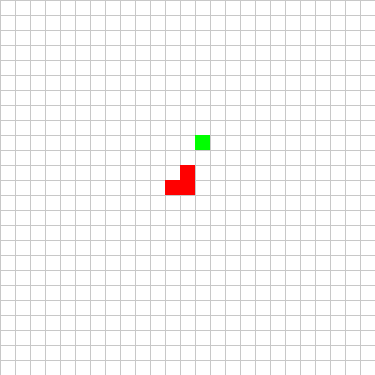

Saved GIF: snake_play.gif


In [45]:
def play_and_record(agent, env, n_steps=500, eps=0.0, fname="snake_play.gif"):
    frames = []
    state = env.reset()
    done = False
    steps = 0
    while not done and steps < n_steps:
        action = agent.select_action(state, eps)
        state, reward, done, _ = env.step(action)
        frame = env.render_frame()
        frames.append(frame)
        steps += 1
    imageio.mimsave(fname, frames, fps=10)
    return fname
gif_path = play_and_record(agent, env, n_steps=500, eps=0.0, fname="snake_play.gif")

from IPython.display import Image, display
display(Image(filename=gif_path))
print("Saved GIF:", gif_path)
